In [9]:
images_path = "../../ImagenesPractica/xview_recognition/"

In [10]:
import uuid
import numpy as np

class GenericObject:
    """
    Generic object data.
    """
    def __init__(self):
        self.id = uuid.uuid4()
        self.bb = (-1, -1, -1, -1)
        self.category= -1

class GenericImage:
    """
    Generic image data.
    """
    def __init__(self, filename):
        self.filename = filename
        self.tile = np.array([-1, -1, -1, -1])  # (pt_x, pt_y, pt_x+width, pt_y+height)
        self.objects = list([])

    def add_object(self, obj: GenericObject):
        self.objects.append(obj)

In [11]:
categories = {13: 'CARGO_PLANE', 15: 'HELICOPTER', 18: 'SMALL_CAR', 19: 'BUS', 23: 'TRUCK', 41: 'MOTORBOAT', 47: 'FISHING_VESSEL', 60: 'DUMP_TRUCK', 64: 'EXCAVATOR', 73: 'BUILDING', 86: 'STORAGE_TANK', 91: 'SHIPPING_CONTAINER'}

In [12]:
import warnings
import rasterio
import numpy as np

def load_geoimage(filename):
    warnings.filterwarnings('ignore', category=rasterio.errors.NotGeoreferencedWarning)
    src_raster = rasterio.open(filename, 'r')
    # RasterIO to OpenCV (see inconsistencies between libjpeg and libjpeg-turbo)
    input_type = src_raster.profile['dtype']
    input_channels = src_raster.count
    img = np.zeros((src_raster.height, src_raster.width, src_raster.count), dtype=input_type)
    for band in range(input_channels):
        img[:, :, band] = src_raster.read(band+1)
    return img

def generator_images(objs, batch_size, do_shuffle=False):
    while True:
        if do_shuffle:
            np.random.shuffle(objs)
        groups = [objs[i:i+batch_size] for i in range(0, len(objs), batch_size)]
        for group in groups:
            images, labels = [], []
            for (filename, obj) in group:
                # Load image
                images.append(load_geoimage(filename))
                probabilities = np.zeros(len(categories))
                probabilities[list(categories.values()).index(obj.category)] = 1
                labels.append(probabilities)
            images = np.array(images).astype(np.float32)
            labels = np.array(labels).astype(np.float32)
            yield images, labels

In [13]:
import json
# Load database
json_file = f'{images_path}xview_ann_train.json'
with open(json_file) as ifs:
    json_data = json.load(ifs)
ifs.close()

In [14]:
import numpy as np
counts = dict.fromkeys(categories.values(), 0)
anns = []
for json_img, json_ann in zip(json_data['images'], json_data['annotations']):
    image = GenericImage(images_path + json_img['file_name'])
    image.tile = np.array([0, 0, json_img['width'], json_img['height']])
    obj = GenericObject()
    obj.id = json_ann['id']
    obj.bb = (int(json_ann['bbox'][0]), int(json_ann['bbox'][1]), int(json_ann['bbox'][2]), int(json_ann['bbox'][3]))
    obj.category = list(categories.values())[json_ann['category_id']-1]
    # Resampling strategy to reduce training time
    if counts[obj.category] >= 5000:
        continue
    counts[obj.category] += 1
    image.add_object(obj)
    anns.append(image)
    
print(counts)

{'CARGO_PLANE': 628, 'HELICOPTER': 49, 'SMALL_CAR': 5000, 'BUS': 5000, 'TRUCK': 5000, 'MOTORBOAT': 1231, 'FISHING_VESSEL': 736, 'DUMP_TRUCK': 1238, 'EXCAVATOR': 706, 'BUILDING': 5000, 'STORAGE_TANK': 1462, 'SHIPPING_CONTAINER': 1522}


C:\Users\Daniel\Desktop\Máster\Asignaturas\Visión por computador\Prácticas\DenseFeedForwardNNImageRecognition


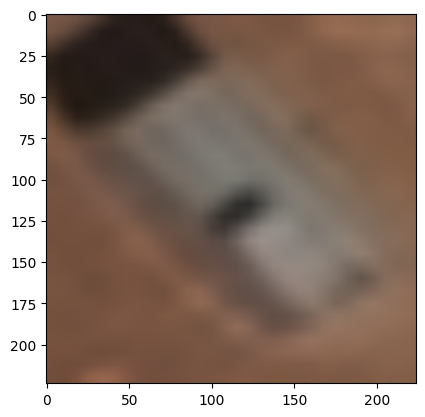

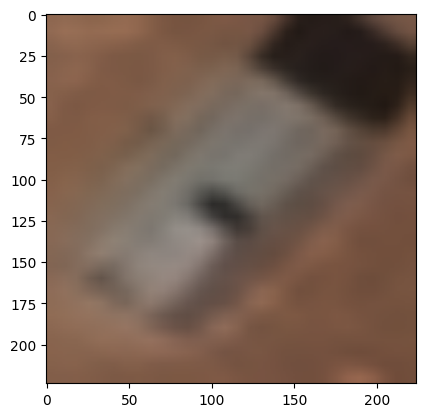

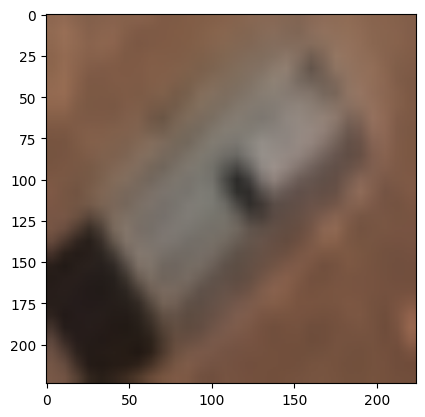

'\nfor ann in anns:\n    # Load image\n    image = load_geoimage(ann.filename)\n    for obj_pred in ann.objects:\n        # Generate prediction\n        warped_image = np.expand_dims(image, 0)\n        print(warped_image)\n        predictions = model.predict(warped_image)\n        # Save prediction\n        pred_category = list(categories.values())[np.argmax(predictions)]\n        pred_score = np.max(predictions)\n        y_true.append(obj_pred.category)\n        y_pred.append(pred_category)\n'

In [32]:
import numpy as np
import cv2
from rasterio.plot import show
import os
print(os.getcwd())
# model.load_weights('model.hdf5', by_name=True)
annotation = anns[0]
my_image = cv2.imread(annotation.filename)
cv2.imwrite('n.tif', my_image)

img_rotate_90_clockwise = cv2.flip(my_image, 1)
cv2.imwrite('n1.tif', img_rotate_90_clockwise)

img_rotate_90_clockwise = cv2.rotate(my_image, cv2.ROTATE_90_COUNTERCLOCKWISE)
cv2.imwrite('n2.tif', img_rotate_90_clockwise)
src = rasterio.open('n.tif')
image = src.read()
show(image)
src = rasterio.open('n1.tif')
image = src.read()
show(image)
src = rasterio.open('n2.tif')
image = src.read()
show(image)
"""
for ann in anns:
    # Load image
    image = load_geoimage(ann.filename)
    for obj_pred in ann.objects:
        # Generate prediction
        warped_image = np.expand_dims(image, 0)
        print(warped_image)
        predictions = model.predict(warped_image)
        # Save prediction
        pred_category = list(categories.values())[np.argmax(predictions)]
        pred_score = np.max(predictions)
        y_true.append(obj_pred.category)
        y_pred.append(pred_category)
"""